# Record Linkage Example

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Load Dataset

We'll use the [Amazon-GoogleProducts](https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution). The dataset is stored in a ZIP file with 3 CSV files: Two are the entity source files, the third one is the perfect mapping.

Let's download the ZIP:

In [6]:
import urllib
import tempfile

dataset_url = 'https://dbs.uni-leipzig.de/file/Amazon-GoogleProducts.zip'
tf = tempfile.NamedTemporaryFile(mode='r', delete=False)
tf.close()

urllib.request.urlretrieve(dataset_url, tf.name);

Extracting the files:

In [7]:
import zipfile
import os

td = tempfile.TemporaryDirectory()

with zipfile.ZipFile(tf.name, "r") as zf:
    zf.extractall(td.name)

os.listdir(td.name)

['Amazon.csv', 'GoogleProducts.csv', 'Amzon_GoogleProducts_perfectMapping.csv']

Now we must read the **two** CSV files `'Amazon.csv'` and `'GoogleProducts.csv'` into a **single** `dict` called `record_dict`. Therefore, `record_dict` will contain all records from the dataset, i.e., all records from both files.

We'll dynamically attribute an `id` to each record using `enumerate`. Entity Embed needs that.

Also, to keep track of what's source file of a record, we must keep a `__source`.

In [8]:
import csv

from entity_embed.data_utils.utils import Enumerator

id_enumerator = Enumerator()
record_dict = {}
source_field = '__source'
left_source = 'amazon'
right_source = 'google'

with open(f'{td.name}/Amazon.csv', newline='', encoding="latin1") as f:
    for record in csv.DictReader(f):
        record['id'] = id_enumerator[record["id"]]
        record[source_field] = left_source
        del record['description']  # drop description, for benchmarking
        record_dict[record['id']] = record

with open(f'{td.name}/GoogleProducts.csv', newline='', encoding="latin1") as f:
    for record in csv.DictReader(f):
        record['id'] = id_enumerator[record["id"]]
        record['title'] = record.pop('name')  # in Google, title is called name
        record[source_field] = right_source
        del record['description']  # drop description, for benchmarking
        record_dict[record['id']] = record

Now we get the `pos_pair_set`:

In [9]:
pos_pair_set = set()

with open(f'{td.name}/Amzon_GoogleProducts_perfectMapping.csv', newline='') as f:
    for row in csv.DictReader(f):
        id_left = id_enumerator[row['idAmazon']]
        id_right = id_enumerator[row['idGoogleBase']]
        pos_pair_set.add((id_left, id_right))

len(pos_pair_set)

1300

Note internally Entity Embed will use **clusters, not pairs**.

For this dataset, the number of clusters is smaller than the number of pairs, because some clusters have more than 2 records. For example, a cluster with 3 records means 2 records from a file link to 1 record from the other file. This is not a problem for Entity Embed. In fact, it's important for Entity Embed to know the full clusters in order to learn better embeddings. See an example here:

In [10]:
from entity_embed.data_utils import utils

cluster_mapping, cluster_dict = utils.id_pairs_to_cluster_mapping_and_dict(pos_pair_set, record_dict)
len(cluster_dict)

3290

In [11]:
cluster_dict[4]

[262, 2485, 2488]

In [12]:
[cluster_mapping[id_] for id_ in cluster_dict[4]]

[4, 4, 4]

To use clusters, we must assign them to each record on a `cluster_field` key:

In [13]:
cluster_field = 'cluster'
utils.assign_clusters(record_dict, cluster_field, cluster_mapping)

for id_ in cluster_dict[4]:
    display(record_dict[id_])

{'id': 262,
 'title': 'hp sp linux we 50 lic/cd 3.0c ( t3586a )',
 'manufacturer': 'hewlett packard (consumables)',
 'price': '0',
 '__source': 'amazon',
 'cluster': 4}

{'id': 2485,
 'manufacturer': '',
 'price': '69216.95',
 'title': 'sp linux we 50 lic/cd 3.0c',
 '__source': 'google',
 'cluster': 4}

{'id': 2488,
 'manufacturer': '',
 'price': '69216.95',
 'title': 'sp linux we 50 lic/cd 3.0c',
 '__source': 'google',
 'cluster': 4}

Note that there are additional pairs in clusters when compared to `pos_pair_set`. That's because it's useful for Entity Embed to also learn that cases like `(2485, 2488)` represent the same entity, even though they belong to the same dataset and won't be returned in the final pairwise results:

In [14]:
from entity_embed.data_utils.utils import cluster_dict_to_id_pairs

len(cluster_dict_to_id_pairs(cluster_dict) - pos_pair_set)

253

From all clusters, we'll use only 50% for training, and other 20% for validation, and the remaining 30% for test:

In [15]:
from entity_embed.data_utils import utils

train_record_dict, valid_record_dict, test_record_dict = utils.split_record_dict_on_clusters(
    record_dict=record_dict,
    cluster_field=cluster_field,
    train_proportion=0.5,
    valid_proportion=0.2,
    random_seed=random_seed)

20:07:59 INFO:Singleton cluster sizes (train, valid, test):(1092, 437, 656)
20:07:59 INFO:Plural cluster sizes (train, valid, test):(552, 221, 332)


Note we're splitting the data on **clusters**, not records, so the record counts vary:

In [16]:
len(train_record_dict), len(valid_record_dict), len(test_record_dict)

(2307, 913, 1369)

Clean up the temporary files:

In [17]:
import os

td.cleanup()
os.remove(tf.name)

## Preprocess

We'll perform a very minimal preprocessing of the dataset. We want to simply force ASCII chars, lowercase all chars, and strip leading and trailing whitespace.

The fields we'll clean are the ones we'll use:

In [18]:
field_list = ['title', 'manufacturer', 'price']

In [19]:
import unidecode

def clean_str(s):
    return unidecode.unidecode(s).lower().strip()

for record in record_dict.values():
    for field in field_list:
        record[field] = clean_str(record[field])

Forcing ASCII chars in this dataset is useful to improve recall because there's little difference between accented and not-accented chars here. Also, this dataset contains mostly latin chars.

## Configure Entity Embed fields

Now we will define how record fields will be numericalized and encoded by the neural network. First we set an `alphabet`, here we'll use ASCII numbers, letters, symbols and space:

In [20]:
from entity_embed.data_utils.field_config_parser import DEFAULT_ALPHABET

alphabet = DEFAULT_ALPHABET
''.join(alphabet)

'0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '

It's worth noting you can use any alphabet you need, so the accent removal we performed is optional.

Then we set an `field_config_dict`. It defines `field_type`s that determine how fields are processed in the neural network:

In [21]:
field_config_dict = {
    'title': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'title_semantic': {
        'key': 'title',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
    },
    'manufacturer': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'price': {
        'field_type': "STRING",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    }
}

Then we use our `field_config_dict` to get a `record_numericalizer`. This object will convert the strings from our records into tensors for the neural network.

The same `record_numericalizer` must be used on ALL data: train, valid, test. This ensures numericalization will be consistent. Therefore, we pass `record_list=record_dict.values()`:

In [22]:
from entity_embed import FieldConfigDictParser

record_numericalizer = FieldConfigDictParser.from_dict(field_config_dict, record_list=record_dict.values())

20:07:59 INFO:For field=title, computing actual max_str_len
20:07:59 INFO:For field=title, using actual_max_str_len=26
20:07:59 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
20:08:02 INFO:For field=manufacturer, computing actual max_str_len
20:08:02 INFO:actual_max_str_len=15 must be even to enable NN pooling. Updating to 16
20:08:02 INFO:For field=manufacturer, using actual_max_str_len=16
20:08:02 INFO:For field=price, computing actual max_str_len
20:08:02 INFO:For field=price, using actual_max_str_len=12


## Initialize Data Module

Under the hood, Entity Embed uses [pytorch-lightning](https://pytorch-lightning.readthedocs.io/en/latest/), so we need to create a datamodule object:

In [23]:
from entity_embed import LinkageDataModule

batch_size = 32
eval_batch_size = 64
datamodule = LinkageDataModule(
    train_record_dict=train_record_dict,
    valid_record_dict=valid_record_dict,
    test_record_dict=test_record_dict,
    source_field=source_field,
    left_source=left_source,
    cluster_field=cluster_field,
    record_numericalizer=record_numericalizer,
    batch_size=batch_size,
    eval_batch_size=eval_batch_size,
    random_seed=random_seed
)

We've used `LinkageDataModule` because we're doing Record Linkage of a multiple datasets/tables.

We're NOT doing Deduplication of a single dataset here. Check the other notebook [Deduplication-Example](./Deduplication-Example.ipynb) if you want to learn how to do it with Entity Embed.

## Training

Now the training process! Thanks to pytorch-lightning, it's easy to train, validate, and test with the same datamodule.

We must choose the K of the Approximate Nearest Neighbors, i.e., the top K neighbors our model will use to find duplicates in the embedding space. Below we're setting it on `ann_k` and initializing the `LinkageEmbed` model object:

In [24]:
from entity_embed import LinkageEmbed

ann_k = 100
model = LinkageEmbed(
    record_numericalizer,
    ann_k=ann_k,
    source_field=source_field,
    left_source=left_source,
)

To train, Entity Embed uses [pytorch-lightning Trainer](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html) on it's `LinkageEmbed.fit` method.

Since Entity Embed is focused in recall, we'll use `valid_recall_at_0.3` for early stopping. But we'll set `min_epochs = 5` to avoid a very low precision.

`0.3` here is the threshold for **cosine similarity of embedding vectors**, so possible values are between -1 and 1. We're using a validation metric, and the training process will run validation on every epoch end due to `check_val_every_n_epoch=1`.

We also set `tb_name` and `tb_save_dir` to use Tensorboard. Run `tensorboard --logdir notebooks/tb_logs` to check the train and valid metrics during and after training.

In [25]:
trainer = model.fit(
    datamodule,
    min_epochs=5,
    max_epochs=100,
    check_val_every_n_epoch=1,
    early_stop_monitor="valid_recall_at_0.3",
    tb_save_dir='tb_logs',
    tb_name='amazon-google',
)

20:08:03 INFO:GPU available: True, used: True
20:08:03 INFO:TPU available: False, using: 0 TPU cores
20:08:03 INFO:Train positive pair count: 663
20:08:03 INFO:Valid positive pair count: 256
20:08:03 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
20:08:19 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 7.4 M 
1 | loss_fn     | SupConLoss | 0     
-------------------------------------------
5.7 M     Trainable params
1.7 M     Non-trainable params
7.4 M     Total params
29.454    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

20:11:04 INFO:Loading the best validation model from tb_logs/amazon-google/version_8/checkpoints/epoch=13-step=1025.ckpt...


`LinkageEmbed.fit` keeps only the weights of the best validation model. With them, we can check the best performance on validation set:

In [26]:
model.validate(datamodule)

{'valid_f1_at_0.3': 0.2175767918088737,
 'valid_f1_at_0.5': 0.6325224071702945,
 'valid_f1_at_0.7': 0.7824561403508772,
 'valid_pair_entity_ratio_at_0.3': 2.2869660460021906,
 'valid_pair_entity_ratio_at_0.5': 0.5750273822562979,
 'valid_pair_entity_ratio_at_0.7': 0.343921139101862,
 'valid_precision_at_0.3': 0.1221264367816092,
 'valid_precision_at_0.5': 0.4704761904761905,
 'valid_precision_at_0.7': 0.7101910828025477,
 'valid_recall_at_0.3': 0.99609375,
 'valid_recall_at_0.5': 0.96484375,
 'valid_recall_at_0.7': 0.87109375}

And we can check which fields are most important for the final embedding:

In [27]:
model.get_pool_weights()

{'title': 0.37132519483566284,
 'title_semantic': 0.3634147346019745,
 'manufacturer': 0.13500668108463287,
 'price': 0.1302533894777298}

## Testing

Again with the best validation model, we can check the performance on the test set:

In [28]:
model.test(datamodule)

20:11:06 INFO:Test positive pair count: 381


{'test_f1_at_0.3': 0.15837860426243208,
 'test_f1_at_0.5': 0.5413870246085011,
 'test_f1_at_0.7': 0.7184241019698725,
 'test_pair_entity_ratio_at_0.3': 3.2176771365960555,
 'test_pair_entity_ratio_at_0.5': 0.7012417823228634,
 'test_pair_entity_ratio_at_0.7': 0.352081811541271,
 'test_precision_at_0.3': 0.08603859250851305,
 'test_precision_at_0.5': 0.378125,
 'test_precision_at_0.7': 0.6431535269709544,
 'test_recall_at_0.3': 0.994750656167979,
 'test_recall_at_0.5': 0.952755905511811,
 'test_recall_at_0.7': 0.8136482939632546}

Entity Embed achieves Recall of ~0.99 with Pair-Entity ratio below 100 on a variety of datasets. **Entity Embed aims for high recall at the expense of precision. Therefore, this library is suited for the Blocking/Indexing stage of an Entity Resolution pipeline.**  A scalabale and noise-tolerant Blocking procedure is often the main bottleneck for performance and quality on Entity Resolution pipelines, so this library aims to solve that. Note the ANN search on embedded records returns several candidate pairs that must be filtered to find the best matching pairs, possibly with a pairwise classifier. See [Matching](#Matching) section below

## t-sne visualization

Let's visualize a small sample of the test embeddings and see if they look properly clustered. First, get the embedding vectors:

In [29]:
test_left_vector_dict, test_right_vector_dict = model.predict(
    record_dict=test_record_dict,
    batch_size=eval_batch_size
)

# batch embedding:   0%|          | 0/22 [00:00<?, ?it/s]

Then, produce the visualization:

In [30]:
vis_sample_size = 10

In [31]:
test_vector_dict = {**test_left_vector_dict, **test_right_vector_dict}
test_cluster_dict = utils.record_dict_to_cluster_dict(test_record_dict, cluster_field)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [32]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [33]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=20, square_distances=True, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

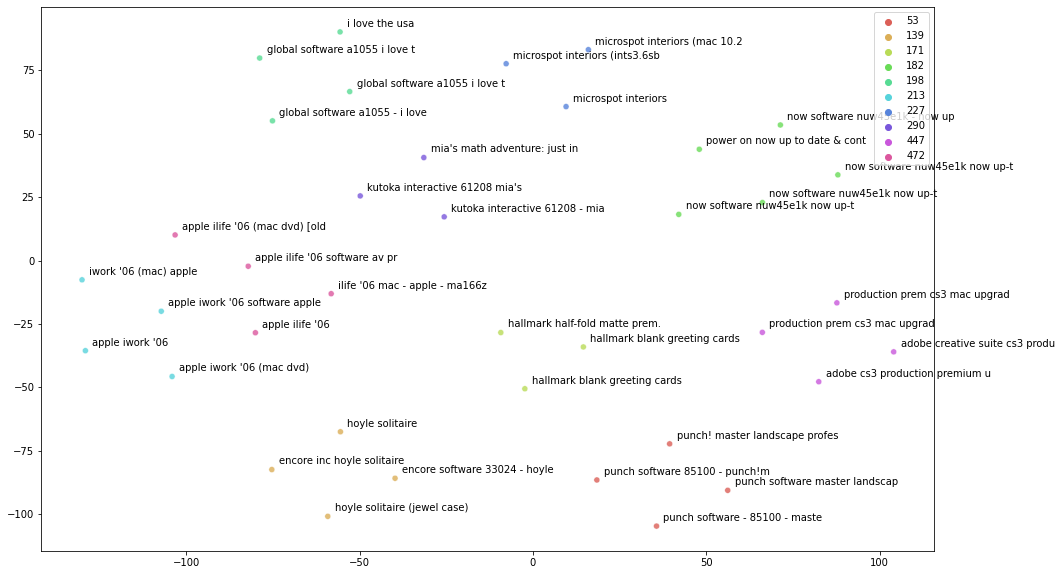

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_record_dict[id_]['title'][:30]
    ax.text(x + 2, y + 2, text)

## Testing manually (like a production run)

When running in production, you only have access to the trained `model` object and the production `record_dict` (without the `cluster_field` filled, of course).

So let's simulate that by removing `cluster_field` from the `test_record_dict`:

In [35]:
import copy

prod_test_record_dict = copy.deepcopy(test_record_dict)

for record in prod_test_record_dict.values():
    del record[cluster_field]

Then call `predict_pairs` with some `ann_k` and `sim_threshold`:

In [36]:
sim_threshold = 0.3

found_pair_set = model.predict_pairs(
    record_dict=prod_test_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold
)
len(found_pair_set)

# batch embedding:   0%|          | 0/22 [00:00<?, ?it/s]

4405

Let's check now the metrics of the found duplicate pairs:

In [37]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(prod_test_record_dict))

3.2176771365960555

In [38]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, datamodule.test_pos_pair_set)

(0.08603859250851305, 0.994750656167979)

Same numbers of the `trainer.test`, so our manual testing is fine.

Finally, we can check the false positives and negatives to see if they're really difficult:

In [39]:
false_positives = list(found_pair_set - datamodule.test_pos_pair_set)
len(false_positives)

4026

In [40]:
false_negatives = list(datamodule.test_pos_pair_set - found_pair_set)
len(false_negatives)

2

In [41]:
cos_similarity = lambda a, b: np.dot(a, b)

In [42]:
for (id_left, id_right) in false_positives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            utils.subdict(record_dict[id_left], field_list), utils.subdict(record_dict[id_right], field_list)
        )
    )

(0.31519946,
 {'title': 'microsoft windows terminal server 2003 client additional license for users- 5 user',
  'manufacturer': 'microsoft',
  'price': '669'},
 {'title': 'microsoft academic microsoft office project 2003 standard',
  'manufacturer': '',
  'price': '69.95'})

(0.3284967,
 {'title': 'captain america the complete comic collection win/mac',
  'manufacturer': 'git corp',
  'price': '49.95'},
 {'title': 'the sims expansion collection vol 1',
  'manufacturer': '',
  'price': '8.72'})

(0.52083033,
 {'title': 'hoyle: classic collection 2006',
  'manufacturer': 'encore',
  'price': '19.99'},
 {'title': 'encore software 11050 - hoyle 4-pack 2006 - win 98 me 2000 xp',
  'manufacturer': '',
  'price': '18.97'})

In [43]:
for (id_left, id_right) in false_negatives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            utils.subdict(record_dict[id_left], field_list), utils.subdict(record_dict[id_right], field_list)
        )
    )

(0.20618087,
 {'title': 'faxstf pro mac os 10.3.9 or above',
  'manufacturer': 'aladdin systems',
  'price': '49.99'},
 {'title': 'allume systems inc - stfmapbx2 - faxstf pro',
  'manufacturer': '',
  'price': '43.36'})

(0.2653891,
 {'title': 'quickbooks premier manufacturer and wholesale edition 2007',
  'manufacturer': 'intuit',
  'price': '399.95'},
 {'title': 'intuit inc 299529 qb prem mfg & whlesle 07 (intuit inc 299529)',
  'manufacturer': '',
  'price': '335.99'})

## Matching

It's still necessary to filter `found_pair_set` with a slower but more precise pairwise classifier.

To do that, let's first save our model and data:

In [44]:
model.trainer.checkpoint_callback.best_model_path

'tb_logs/amazon-google/version_8/checkpoints/epoch=13-step=1025.ckpt'

In [45]:
!mkdir -p ../trained-models/notebooks/rl/
!cp {model.trainer.checkpoint_callback.best_model_path} ../trained-models/notebooks/rl/rl-model.ckpt

In [46]:
import json

with open('../trained-models/notebooks/rl/rl-train-records.json', 'w') as f:
    json.dump(datamodule.train_record_dict, f, indent=4)

with open('../trained-models/notebooks/rl/rl-valid-records.json', 'w') as f:
    json.dump(datamodule.valid_record_dict, f, indent=4)

with open('../trained-models/notebooks/rl/rl-test-records.json', 'w') as f:
    json.dump(datamodule.test_record_dict, f, indent=4)

In [47]:
import json

with open('../trained-models/notebooks/rl/rl-train-pos-pairs.json', 'w') as f:
    json.dump([list(pair) for pair in datamodule.train_pos_pair_set], f, indent=4)

with open('../trained-models/notebooks/rl/rl-valid-pos-pairs.json', 'w') as f:
    json.dump([list(pair) for pair in datamodule.valid_pos_pair_set], f, indent=4)

with open('../trained-models/notebooks/rl/rl-test-pos-pairs.json', 'w') as f:
    json.dump([list(pair) for pair in datamodule.test_pos_pair_set], f, indent=4)

Then, let's proceed with matching on [End-to-End-Matching-Example.ipynb](./End-to-End-Matching-Example.ipynb).